# Information Retrieval Submission
Experiment: Can bm25 plus bert give better results than bm25 alone?

### Step 1: Import libraries

We will use [tira](https://tira.io/), an information retrieval shared task platform, and [ir_dataset](https://ir-datasets.com/) for loading the datasets. Subsequently, we will build a retrieval system with [PyTerrier](https://github.com/terrier-org/pyterrier), an open-source search engine framework.

First, we need to install the required libraries.

In [5]:
# !pip3 install 'tira>=0.0.139' ir-datasets 'python-terrier==0.10.0'

# ! pip install git+https://github.com/terrier-org/pyterrier_colbert.git


In [6]:

! echo $JAVA_HOME


/usr/local/sdkman/candidates/java/current


In [7]:
from tira.third_party_integrations import ensure_pyterrier_is_loaded
from tira.rest_api_client import Client

ensure_pyterrier_is_loaded()
tira = Client()

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTerrier 0.10.0 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


Create an API client to interact with the TIRA platform (e.g., to load datasets and submit runs).

In [8]:
# PyTerrier must be imported after `ensure_pyterrier_is_loaded` is called.

from pyterrier import started, init

if not started():
    init()

### Step 2: Load the dataset

We load the dataset by its ir_datasets ID (as listed in the Readme). Just be sure to add the `irds:` prefix before the dataset ID to tell PyTerrier to load the data from ir_datasets.

In [9]:

from pyterrier import get_dataset
from transformers import BertTokenizer, BertModel

pt_dataset = get_dataset('irds:ir-lab-wise-2024/subsampled-ms-marco-deep-learning-20241201-training')

### Step 3: Build an index

We will then create an index from the documents in the dataset we just loaded.

In [10]:
from pyterrier import IterDictIndexer

indexer = IterDictIndexer(
    # Store the index in the `index` directory.
    "../data/index",
    meta={'docno': 50, 'text': 4096},
    # If an index already exists there, then overwrite it.
    overwrite=True,
)
index = indexer.index(pt_dataset.get_corpus_iter())

ir-lab-wise-2024/subsampled-ms-marco-deep-learning-20241201-training documents:  38%|███▊      | 26058/68261 [00:08<00:10, 4179.39it/s]

12:42:05.936 [ForkJoinPool-1-worker-1] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (6114613) - further warnings are suppressed


ir-lab-wise-2024/subsampled-ms-marco-deep-learning-20241201-training documents: 100%|██████████| 68261/68261 [00:13<00:00, 4945.83it/s]


12:42:13.410 [ForkJoinPool-1-worker-1] WARN org.terrier.structures.indexing.Indexer - Indexed 1 empty documents


### Step 4: Define the retrieval pipeline

We will define a simple retrieval pipeline using just BM25 as a baseline. For details, refer to the PyTerrier [documentation](https://pyterrier.readthedocs.io) or [tutorial](https://github.com/terrier-org/ecir2021tutorial).

In [11]:
import pyterrier as pt
print(pt.__version__)
! pip install --upgrade pyterrier

print(pt.__version__)

0.10.0
0.10.0


In [12]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
from tqdm import tqdm



bm25 = pt.BatchRetrieve(index, wmodel="BM25")

corpus = pt_dataset.get_corpus_iter()  # Use this to load the corpus

# Create a document lookup dictionary
doc_lookup = {doc["docno"]: doc["text"] for doc in corpus}

# Load the tokenizer and model from HuggingFace (BERT model for dense retrieval)

import torch.nn.functional as F

class BERTReRanker:
    def __init__(self, model_name="cross-encoder/ms-marco-MiniLM-L-6-v2"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)

    def rerank(self, query, docs):
        inputs = self.tokenizer(
            [query] * len(docs),
            docs,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=512
        ).to(self.device)

        with torch.no_grad():
            logits = self.model(**inputs).logits.squeeze(-1).cpu().numpy()

        # Apply sigmoid to get probability scores
        probabilities = torch.sigmoid(torch.tensor(logits)).numpy()

        return probabilities

# Initialize the BERT re-ranker
bert_ranker = BERTReRanker()

def rerank_with_bert(bm25_results, topics):
    reranked = []
    for qid, group in tqdm(bm25_results.groupby("qid"), desc="Re-ranking with BERT"):
        query = topics.loc[topics["qid"] == qid, "query"].values[0]
        docs = group["docid"].values
        doc_texts = [doc_lookup.get(docid, "") for docid in docs]  # Fetch document texts

        # Print the input query and document texts
        print(f"Query: {query}")
        print(f"Document texts: {doc_texts}")

        scores = bert_ranker.rerank(query, doc_texts)

        # Print the BERT scores to check for consistency
        print(f"BERT scores: {scores}")

        group["score"] = scores
        reranked.append(group.sort_values(by="score", ascending=False))

    return pd.concat(reranked)



# Retrieve BM25 results
bm25_results = bm25(pt_dataset.get_topics("text"))
# Custom function to safely merge DataFrames
def safe_merge(df1, df2, on_columns):
    # Ensure the columns are consistently named
    df1.rename(columns={'qid': 'query_id', 'docid': 'doc_id'}, inplace=True)
    df2.rename(columns={'qid': 'query_id', 'docid': 'doc_id'}, inplace=True)
    
    # Check if the necessary columns exist in both DataFrames
    for col in on_columns:
        if col not in df1.columns:
            raise KeyError(f"Column '{col}' not found in first DataFrame.")
        if col not in df2.columns:
            raise KeyError(f"Column '{col}' not found in second DataFrame.")
    
    # Ensure that 'query_id' and 'doc_id' columns are the same data type (str)
    df1['query_id'] = df1['query_id'].astype(str)
    df1['doc_id'] = df1['doc_id'].astype(str)
    df2['query_id'] = df2['query_id'].astype(str)
    df2['doc_id'] = df2['doc_id'].astype(str)
    
    # Merge the two DataFrames on the specified columns
    merged = pd.merge(
        df1, df2, on=on_columns, suffixes=("_bm25", "_bert"), how="outer"
    )
    
    # Handle missing values and combine scores
    merged.fillna(0, inplace=True)
    merged["score"] = merged["score_bm25"] + merged["score_bert"]
    
    # Sort by query_id and descending score, then rank the results
    merged = merged.sort_values(by=["query_id", "score"], ascending=[True, False])
    merged["rank"] = merged.groupby("query_id").cumcount() + 1
    
    return merged[["query_id", "doc_id", "score", "rank"]]

def combsum_fusion(results1, results2):
    # Safe merge of the results from BM25 and BERT
    merged_results = safe_merge(results1, results2, on_columns=["query_id", "doc_id"])
    
    return merged_results
# Re-rank BM25 results with BERT

# Re-rank BM25 results with BERT
bert_results = rerank_with_bert(bm25_results, pt_dataset.get_topics())



ir-lab-wise-2024/subsampled-ms-marco-deep-learning-20241201-training documents: 100%|██████████| 68261/68261 [00:00<00:00, 127642.00it/s]


There are multiple query fields available: ('text', 'title', 'query', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.


Re-ranking with BERT:   0%|          | 0/97 [00:00<?, ?it/s]

Query: who is aziz hashim
Document texts: ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

Re-ranking with BERT:   1%|          | 1/97 [00:02<03:30,  2.20s/it]

BERT scores: [3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05
 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05
 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05
 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05
 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05
 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05
 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05
 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05
 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05
 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05
 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05
 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05
 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05
 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05
 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-05 3.720898e-

Re-ranking with BERT:   2%|▏         | 2/97 [00:04<03:18,  2.09s/it]

BERT scores: [2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05
 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05
 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05
 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05
 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05
 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05
 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05
 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05
 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05
 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05
 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05
 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05
 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05
 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.6078586e-05 2.60785

Re-ranking with BERT:   3%|▎         | 3/97 [00:05<02:54,  1.86s/it]

BERT scores: [3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05
 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05
 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05
 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05
 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05
 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05
 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05
 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05
 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05
 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05
 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05
 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05
 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05
 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05
 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-05 3.610304e-

Re-ranking with BERT:   4%|▍         | 4/97 [00:08<03:07,  2.02s/it]

BERT scores: [0.00047015 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015
 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015
 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015
 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015
 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015
 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015
 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015
 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015
 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015
 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015
 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015
 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015
 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015
 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015 0.00047015
 0.00047015 0.00047015 0.00047015 0.00047015 0.00

Re-ranking with BERT:   5%|▌         | 5/97 [00:10<03:05,  2.02s/it]

BERT scores: [3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05
 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05
 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05
 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05
 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05
 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05
 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05
 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05
 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05
 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05
 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05
 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05
 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05
 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.0941395e-05 3.09413

Re-ranking with BERT:   6%|▌         | 6/97 [00:11<02:53,  1.91s/it]

BERT scores: [0.00031142 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142
 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142
 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142
 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142
 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142
 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142
 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142
 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142
 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142
 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142
 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142
 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142
 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142
 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142 0.00031142
 0.00031142 0.00031142 0.00031142 0.00031142 0.00

Re-ranking with BERT:   7%|▋         | 7/97 [00:15<03:38,  2.43s/it]

BERT scores: [2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05
 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05
 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05
 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05
 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05
 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05
 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05
 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05
 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05
 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05
 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05
 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05
 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05
 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.7147762e-05 2.71477

Re-ranking with BERT:   8%|▊         | 8/97 [00:17<03:33,  2.40s/it]

BERT scores: [8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05
 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05
 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05
 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05
 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05
 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05
 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05
 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05
 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05
 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05
 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05
 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05
 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05
 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05
 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-05 8.503536e-

Re-ranking with BERT:   9%|▉         | 9/97 [00:20<03:38,  2.48s/it]

BERT scores: [0.00050768 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768
 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768
 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768
 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768
 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768
 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768
 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768
 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768
 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768
 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768
 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768
 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768
 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768
 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768 0.00050768
 0.00050768 0.00050768 0.00050768 0.00050768 0.00

Re-ranking with BERT:  10%|█         | 10/97 [00:22<03:29,  2.41s/it]

BERT scores: [6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05
 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05
 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05
 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05
 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05
 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05
 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05
 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05
 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05
 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05
 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05
 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05
 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05
 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.7742665e-05 6.77426

Re-ranking with BERT:  11%|█▏        | 11/97 [00:23<03:01,  2.11s/it]

BERT scores: [5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05
 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05
 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05
 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05
 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05
 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05
 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05
 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05
 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05
 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05
 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05
 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05
 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05
 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05
 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-05 5.798473e-

Re-ranking with BERT:  12%|█▏        | 12/97 [00:25<02:47,  1.97s/it]

BERT scores: [8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05
 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05
 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05
 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05
 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05
 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05
 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05
 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05
 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05
 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05
 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05
 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05
 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05
 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05
 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-05 8.255783e-

Re-ranking with BERT:  13%|█▎        | 13/97 [00:27<02:46,  1.99s/it]

BERT scores: [0.00049849 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849
 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849
 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849
 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849
 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849
 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849
 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849
 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849
 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849
 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849
 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849
 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849
 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849
 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849 0.00049849
 0.00049849 0.00049849 0.00049849 0.00049849 0.00

Re-ranking with BERT:  14%|█▍        | 14/97 [00:30<03:01,  2.18s/it]

BERT scores: [2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05
 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05
 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05
 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05
 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05
 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05
 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05
 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05
 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05
 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05
 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05
 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05
 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05
 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.7203143e-05 2.72031

Re-ranking with BERT:  15%|█▌        | 15/97 [00:32<03:01,  2.21s/it]

BERT scores: [3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05
 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05
 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05
 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05
 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05
 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05
 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05
 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05
 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05
 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05
 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05
 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05
 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05
 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.0445184e-05 3.04451

Re-ranking with BERT:  16%|█▋        | 16/97 [00:33<02:31,  1.87s/it]

BERT scores: [0.00066868 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868
 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868
 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868
 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868
 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868
 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868
 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868
 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868
 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868
 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868
 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868
 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868
 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868
 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868 0.00066868
 0.00066868 0.00066868 0.00066868 0.00066868 0.00

Re-ranking with BERT:  18%|█▊        | 17/97 [00:34<02:15,  1.70s/it]

BERT scores: [2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05
 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05
 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05
 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05
 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05
 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05
 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05
 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05
 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05
 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05
 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05
 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05
 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05
 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.2107066e-05 2.21070

Re-ranking with BERT:  19%|█▊        | 18/97 [00:37<02:40,  2.03s/it]

BERT scores: [3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05
 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05
 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05
 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05
 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05
 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05
 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05
 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05
 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05
 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05
 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05
 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05
 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05
 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.6844867e-05 3.68448

Re-ranking with BERT:  20%|█▉        | 19/97 [00:40<03:06,  2.39s/it]

BERT scores: [1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05
 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05
 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05
 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05
 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05
 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05
 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05
 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05
 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05
 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05
 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05
 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05
 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05
 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.6621356e-05 1.66213

Re-ranking with BERT:  21%|██        | 20/97 [00:42<02:51,  2.23s/it]

BERT scores: [2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05
 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05
 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05
 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05
 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05
 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05
 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05
 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05
 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05
 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05
 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05
 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05
 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05
 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.6251078e-05 2.62510

Re-ranking with BERT:  22%|██▏       | 21/97 [00:44<02:42,  2.13s/it]

BERT scores: [2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05
 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05
 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05
 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05
 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05
 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05
 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05
 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05
 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05
 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05
 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05
 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05
 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05
 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.8272416e-05 2.82724

Re-ranking with BERT:  23%|██▎       | 22/97 [00:46<02:42,  2.17s/it]

BERT scores: [4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05
 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05
 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05
 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05
 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05
 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05
 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05
 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05
 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05
 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05
 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05
 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05
 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05
 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.0110102e-05 4.01101

Re-ranking with BERT:  24%|██▎       | 23/97 [00:48<02:20,  1.89s/it]

BERT scores: [2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05
 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05
 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05
 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05
 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05
 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05
 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05
 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05
 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05
 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05
 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05
 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05
 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05
 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.5033654e-05 2.50336

Re-ranking with BERT:  25%|██▍       | 24/97 [00:50<02:27,  2.02s/it]

BERT scores: [0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974
 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974
 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974
 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974
 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974
 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974
 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974
 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974
 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974
 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974
 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974
 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974
 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974
 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0001974 0.0

Re-ranking with BERT:  26%|██▌       | 25/97 [00:53<02:41,  2.24s/it]

BERT scores: [1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05
 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05
 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05
 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05
 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05
 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05
 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05
 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05
 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05
 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05
 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05
 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05
 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05
 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.9511199e-05 1.95111

Re-ranking with BERT:  27%|██▋       | 26/97 [00:55<02:28,  2.09s/it]

BERT scores: [4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05
 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05
 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05
 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05
 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05
 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05
 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05
 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05
 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05
 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05
 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05
 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05
 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05
 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.9626055e-05 4.96260

Re-ranking with BERT:  28%|██▊       | 27/97 [00:58<02:56,  2.52s/it]

BERT scores: [0.00012174 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174
 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174
 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174
 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174
 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174
 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174
 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174
 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174
 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174
 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174
 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174
 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174
 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174
 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174 0.00012174
 0.00012174 0.00012174 0.00012174 0.00012174 0.00

Re-ranking with BERT:  29%|██▉       | 28/97 [01:01<02:53,  2.52s/it]

BERT scores: [3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05
 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05
 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05
 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05
 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05
 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05
 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05
 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05
 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05
 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05
 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05
 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05
 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05
 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.0593936e-05 3.05939

Re-ranking with BERT:  30%|██▉       | 29/97 [01:03<02:41,  2.37s/it]

BERT scores: [2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05
 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05
 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05
 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05
 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05
 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05
 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05
 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05
 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05
 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05
 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05
 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05
 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05
 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.3299017e-05 2.32990

Re-ranking with BERT:  31%|███       | 30/97 [01:05<02:31,  2.26s/it]

BERT scores: [2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05
 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05
 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05
 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05
 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05
 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05
 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05
 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05
 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05
 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05
 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05
 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05
 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05
 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05
 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-05 2.525375e-

Re-ranking with BERT:  32%|███▏      | 31/97 [01:07<02:23,  2.18s/it]

BERT scores: [6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05
 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05
 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05
 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05
 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05
 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05
 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05
 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05
 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05
 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05
 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05
 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05
 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05
 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.6176224e-05 6.61762

Re-ranking with BERT:  33%|███▎      | 32/97 [01:08<02:10,  2.01s/it]

BERT scores: [0.00079093 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093
 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093
 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093
 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093
 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093
 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093
 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093
 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093
 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093
 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093
 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093
 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093
 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093
 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093 0.00079093
 0.00079093 0.00079093 0.00079093 0.00079093 0.00

Re-ranking with BERT:  34%|███▍      | 33/97 [01:11<02:15,  2.12s/it]

BERT scores: [5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05
 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05
 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05
 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05
 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05
 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05
 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05
 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05
 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05
 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05
 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05
 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05
 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05
 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05
 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-05 5.675443e-

Re-ranking with BERT:  35%|███▌      | 34/97 [01:13<02:12,  2.10s/it]

BERT scores: [3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05
 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05
 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05
 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05
 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05
 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05
 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05
 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05
 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05
 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05
 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05
 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05
 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05
 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05
 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-05 3.571291e-

Re-ranking with BERT:  36%|███▌      | 35/97 [01:14<02:04,  2.01s/it]

BERT scores: [3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05
 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05
 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05
 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05
 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05
 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05
 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05
 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05
 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05
 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05
 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05
 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05
 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05
 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05
 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-05 3.399874e-

Re-ranking with BERT:  37%|███▋      | 36/97 [01:16<01:53,  1.86s/it]

BERT scores: [5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05
 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05
 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05
 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05
 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05
 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05
 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05
 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05
 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05
 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05
 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05
 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05
 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05
 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.5341592e-05 5.53415

Re-ranking with BERT:  38%|███▊      | 37/97 [01:18<01:54,  1.91s/it]

BERT scores: [1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05
 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05
 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05
 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05
 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05
 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05
 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05
 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05
 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05
 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05
 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05
 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05
 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05
 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.8789302e-05 1.87893

Re-ranking with BERT:  39%|███▉      | 38/97 [01:20<01:56,  1.97s/it]

BERT scores: [0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047
 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047
 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047
 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047
 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047
 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047
 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047
 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047
 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047
 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047
 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047
 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047
 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047
 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0026047 0.0

Re-ranking with BERT:  40%|████      | 39/97 [01:23<02:13,  2.30s/it]

BERT scores: [0.00203309 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309
 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309
 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309
 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309
 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309
 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309
 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309
 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309
 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309
 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309
 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309
 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309
 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309
 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309 0.00203309
 0.00203309 0.00203309 0.00203309 0.00203309 0.00

Re-ranking with BERT:  41%|████      | 40/97 [01:27<02:33,  2.70s/it]

BERT scores: [0.00035186 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186
 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186
 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186
 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186
 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186
 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186
 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186
 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186
 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186
 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186
 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186
 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186
 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186
 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186 0.00035186
 0.00035186 0.00035186 0.00035186 0.00035186 0.00

Re-ranking with BERT:  42%|████▏     | 41/97 [01:28<02:12,  2.36s/it]

BERT scores: [5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05
 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05
 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05
 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05
 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05
 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05
 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05
 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05
 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05
 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05
 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05
 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05
 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05
 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05
 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-05 5.415549e-

Re-ranking with BERT:  43%|████▎     | 42/97 [01:30<01:59,  2.18s/it]

BERT scores: [4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05
 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05
 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05
 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05
 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05
 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05
 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05
 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05
 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05
 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05
 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05
 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05
 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05
 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.2502645e-05 4.25026

Re-ranking with BERT:  44%|████▍     | 43/97 [01:32<01:51,  2.07s/it]

BERT scores: [0.00022046 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046
 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046
 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046
 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046
 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046
 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046
 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046
 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046
 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046
 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046
 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046
 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046
 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046
 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046 0.00022046
 0.00022046 0.00022046 0.00022046 0.00022046 0.00

Re-ranking with BERT:  45%|████▌     | 44/97 [01:34<01:48,  2.05s/it]

BERT scores: [9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05
 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05
 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05
 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05
 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05
 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05
 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05
 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05
 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05
 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05
 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05
 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05
 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05
 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.0513306e-05 9.05133

Re-ranking with BERT:  46%|████▋     | 45/97 [01:36<01:39,  1.92s/it]

BERT scores: [0.00022593 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593
 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593
 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593
 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593
 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593
 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593
 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593
 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593
 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593
 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593
 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593
 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593
 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593
 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593 0.00022593
 0.00022593 0.00022593 0.00022593 0.00022593 0.00

Re-ranking with BERT:  47%|████▋     | 46/97 [01:38<01:53,  2.23s/it]

BERT scores: [0.00021165 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165
 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165
 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165
 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165
 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165
 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165
 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165
 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165
 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165
 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165
 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165
 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165
 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165
 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165 0.00021165
 0.00021165 0.00021165 0.00021165 0.00021165 0.00

Re-ranking with BERT:  48%|████▊     | 47/97 [01:42<02:10,  2.61s/it]

BERT scores: [0.00026552 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552
 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552
 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552
 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552
 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552
 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552
 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552
 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552
 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552
 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552
 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552
 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552
 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552
 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552 0.00026552
 0.00026552 0.00026552 0.00026552 0.00026552 0.00

Re-ranking with BERT:  49%|████▉     | 48/97 [01:44<01:58,  2.43s/it]

BERT scores: [7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05
 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05
 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05
 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05
 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05
 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05
 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05
 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05
 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05
 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05
 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05
 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05
 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05
 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05
 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-05 7.742735e-

Re-ranking with BERT:  51%|█████     | 49/97 [01:46<01:43,  2.17s/it]

BERT scores: [4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05
 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05
 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05
 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05
 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05
 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05
 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05
 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05
 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05
 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05
 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05
 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05
 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05
 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.7311867e-05 4.73118

Re-ranking with BERT:  52%|█████▏    | 50/97 [01:48<01:41,  2.15s/it]

BERT scores: [4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05
 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05
 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05
 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05
 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05
 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05
 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05
 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05
 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05
 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05
 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05
 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05
 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05
 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05
 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-05 4.453937e-

Re-ranking with BERT:  53%|█████▎    | 51/97 [01:51<01:49,  2.39s/it]

BERT scores: [6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05
 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05
 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05
 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05
 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05
 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05
 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05
 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05
 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05
 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05
 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05
 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05
 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05
 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05
 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-05 6.268061e-

Re-ranking with BERT:  54%|█████▎    | 52/97 [01:53<01:43,  2.30s/it]

BERT scores: [4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05
 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05
 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05
 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05
 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05
 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05
 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05
 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05
 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05
 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05
 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05
 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05
 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05
 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.6053992e-05 4.60539

Re-ranking with BERT:  55%|█████▍    | 53/97 [01:54<01:31,  2.09s/it]

BERT scores: [0.00012583 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583
 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583
 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583
 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583
 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583
 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583
 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583
 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583
 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583
 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583
 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583
 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583
 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583
 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583 0.00012583
 0.00012583 0.00012583 0.00012583 0.00012583 0.00

Re-ranking with BERT:  56%|█████▌    | 54/97 [01:56<01:28,  2.07s/it]

BERT scores: [9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05
 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05
 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05
 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05
 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05
 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05
 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05
 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05
 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05
 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05
 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05
 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05
 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05
 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05
 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-05 9.787814e-

Re-ranking with BERT:  57%|█████▋    | 55/97 [01:58<01:22,  1.96s/it]

BERT scores: [6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05
 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05
 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05
 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05
 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05
 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05
 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05
 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05
 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05
 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05
 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05
 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05
 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05
 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05
 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-05 6.330226e-

Re-ranking with BERT:  58%|█████▊    | 56/97 [02:00<01:15,  1.85s/it]

BERT scores: [0.00024993 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993
 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993
 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993
 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993
 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993
 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993
 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993
 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993
 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993
 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993
 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993
 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993
 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993
 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993 0.00024993
 0.00024993 0.00024993 0.00024993 0.00024993 0.00

Re-ranking with BERT:  59%|█████▉    | 57/97 [02:02<01:18,  1.96s/it]

BERT scores: [2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05
 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05
 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05
 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05
 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05
 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05
 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05
 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05
 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05
 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05
 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05
 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05
 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05
 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.6506992e-05 2.65069

Re-ranking with BERT:  60%|█████▉    | 58/97 [02:04<01:18,  2.01s/it]

BERT scores: [2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05
 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05
 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05
 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05
 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05
 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05
 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05
 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05
 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05
 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05
 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05
 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05
 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05
 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.5281317e-05 2.52813

Re-ranking with BERT:  61%|██████    | 59/97 [02:07<01:24,  2.21s/it]

BERT scores: [3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05
 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05
 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05
 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05
 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05
 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05
 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05
 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05
 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05
 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05
 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05
 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05
 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05
 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05
 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-05 3.136818e-

Re-ranking with BERT:  62%|██████▏   | 60/97 [02:09<01:23,  2.25s/it]

BERT scores: [2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05
 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05
 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05
 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05
 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05
 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05
 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05
 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05
 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05
 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05
 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05
 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05
 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05
 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.7981441e-05 2.79814

Re-ranking with BERT:  63%|██████▎   | 61/97 [02:11<01:23,  2.32s/it]

BERT scores: [1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05
 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05
 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05
 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05
 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05
 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05
 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05
 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05
 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05
 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05
 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05
 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05
 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05
 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.8889157e-05 1.88891

Re-ranking with BERT:  64%|██████▍   | 62/97 [02:15<01:33,  2.67s/it]

BERT scores: [0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107
 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107
 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107
 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107
 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107
 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107
 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107
 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107
 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107
 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107
 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107
 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107
 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107 0.000107
 0.000107 0.000107 0.000107 0.000107 0

Re-ranking with BERT:  65%|██████▍   | 63/97 [02:17<01:28,  2.59s/it]

BERT scores: [3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05
 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05
 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05
 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05
 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05
 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05
 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05
 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05
 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05
 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05
 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05
 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05
 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05 3.14141e-05
 3.14141e-05 3.14141e-05 3.14141e-05 3

Re-ranking with BERT:  66%|██████▌   | 64/97 [02:19<01:20,  2.45s/it]

BERT scores: [8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05
 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05
 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05
 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05
 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05
 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05
 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05
 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05
 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05
 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05
 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05
 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05
 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05
 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05
 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-05 8.734135e-

Re-ranking with BERT:  67%|██████▋   | 65/97 [02:23<01:29,  2.79s/it]

BERT scores: [2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05
 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05
 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05
 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05
 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05
 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05
 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05
 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05
 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05
 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05
 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05
 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05
 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05
 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05
 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-05 2.275807e-

Re-ranking with BERT:  68%|██████▊   | 66/97 [02:24<01:12,  2.34s/it]

BERT scores: [0.00027795 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795
 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795
 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795
 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795
 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795
 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795
 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795
 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795
 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795
 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795
 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795
 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795
 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795
 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795 0.00027795
 0.00027795 0.00027795 0.00027795 0.00027795 0.00

Re-ranking with BERT:  69%|██████▉   | 67/97 [02:27<01:12,  2.41s/it]

BERT scores: [7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05
 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05
 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05
 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05
 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05
 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05
 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05
 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05
 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05
 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05
 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05
 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05
 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05
 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05
 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-05 7.570482e-

Re-ranking with BERT:  70%|███████   | 68/97 [02:28<00:55,  1.91s/it]

BERT scores: [0.00037836 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836
 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836
 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836
 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836
 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836
 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836
 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836
 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836
 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836
 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836
 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836
 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836
 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836
 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836 0.00037836
 0.00037836 0.00037836 0.00037836 0.00037836 0.00

Re-ranking with BERT:  71%|███████   | 69/97 [02:31<01:02,  2.25s/it]

BERT scores: [2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05
 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05
 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05
 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05
 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05
 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05
 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05
 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05
 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05
 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05
 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05
 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05
 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05
 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.9378141e-05 2.93781

Re-ranking with BERT:  72%|███████▏  | 70/97 [02:32<00:55,  2.07s/it]

BERT scores: [0.00012454 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454
 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454
 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454
 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454
 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454
 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454
 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454
 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454
 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454
 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454
 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454
 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454
 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454
 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454 0.00012454
 0.00012454 0.00012454 0.00012454 0.00012454 0.00

Re-ranking with BERT:  73%|███████▎  | 71/97 [02:35<00:54,  2.10s/it]

BERT scores: [9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05
 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05
 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05
 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05
 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05
 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05
 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05
 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05
 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05
 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05
 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05
 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05
 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05
 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05
 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-05 9.067313e-

Re-ranking with BERT:  74%|███████▍  | 72/97 [02:36<00:50,  2.04s/it]

BERT scores: [2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05
 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05
 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05
 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05
 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05
 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05
 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05
 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05
 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05
 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05
 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05
 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05
 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05
 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.7953998e-05 2.79539

Re-ranking with BERT:  75%|███████▌  | 73/97 [02:39<00:54,  2.26s/it]

BERT scores: [9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05
 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05
 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05
 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05
 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05
 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05
 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05
 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05
 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05
 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05
 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05
 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05
 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05
 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05
 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-05 9.051727e-

Re-ranking with BERT:  76%|███████▋  | 74/97 [02:41<00:50,  2.21s/it]

BERT scores: [6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05
 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05
 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05
 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05
 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05
 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05
 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05
 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05
 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05
 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05
 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05
 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05
 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05
 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.9759124e-05 6.97591

Re-ranking with BERT:  77%|███████▋  | 75/97 [02:43<00:44,  2.04s/it]

BERT scores: [6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05
 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05
 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05
 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05
 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05
 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05
 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05
 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05
 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05
 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05
 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05
 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05
 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05
 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05
 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-05 6.535785e-

Re-ranking with BERT:  78%|███████▊  | 76/97 [02:46<00:49,  2.33s/it]

BERT scores: [0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014
 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014
 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014
 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014
 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014
 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014
 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014
 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014
 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014
 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014
 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014
 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014
 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014
 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0001014 0.0

Re-ranking with BERT:  79%|███████▉  | 77/97 [02:49<00:49,  2.47s/it]

BERT scores: [0.00019636 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636
 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636
 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636
 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636
 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636
 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636
 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636
 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636
 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636
 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636
 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636
 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636
 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636
 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636 0.00019636
 0.00019636 0.00019636 0.00019636 0.00019636 0.00

Re-ranking with BERT:  80%|████████  | 78/97 [02:51<00:48,  2.53s/it]

BERT scores: [4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05
 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05
 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05
 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05
 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05
 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05
 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05
 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05
 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05
 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05
 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05
 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05
 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05
 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.5115183e-05 4.51151

Re-ranking with BERT:  81%|████████▏ | 79/97 [02:52<00:33,  1.88s/it]

BERT scores: [2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05
 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05
 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05
 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05
 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05
 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05
 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05
 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05
 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05
 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05
 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05
 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05
 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05
 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.9048406e-05 2.90484

Re-ranking with BERT:  82%|████████▏ | 80/97 [02:55<00:39,  2.31s/it]

BERT scores: [0.00026428 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428
 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428
 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428
 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428
 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428
 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428
 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428
 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428
 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428
 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428
 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428
 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428
 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428
 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428 0.00026428
 0.00026428 0.00026428 0.00026428 0.00026428 0.00

Re-ranking with BERT:  84%|████████▎ | 81/97 [02:57<00:36,  2.30s/it]

BERT scores: [0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149
 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149
 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149
 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149
 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149
 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149
 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149
 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149
 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149
 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149
 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149
 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149
 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149 0.000149
 0.000149 0.000149 0.000149 0.000149 0

Re-ranking with BERT:  85%|████████▍ | 82/97 [02:58<00:26,  1.75s/it]

BERT scores: [2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05
 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05
 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05
 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05
 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05
 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05
 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05
 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05
 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05
 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05
 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05
 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05
 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05
 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.8427981e-05 2.84279

Re-ranking with BERT:  86%|████████▌ | 83/97 [02:59<00:23,  1.68s/it]

BERT scores: [9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05
 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05
 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05
 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05
 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05
 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05
 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05
 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05
 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05
 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05
 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05
 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05
 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05
 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.7386015e-05 9.73860

Re-ranking with BERT:  87%|████████▋ | 84/97 [03:02<00:25,  1.95s/it]

BERT scores: [6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05
 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05
 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05
 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05
 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05
 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05
 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05
 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05
 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05
 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05
 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05
 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05
 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05
 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05
 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-05 6.079101e-

Re-ranking with BERT:  89%|████████▊ | 86/97 [03:05<00:18,  1.67s/it]

BERT scores: [0.00010647 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647
 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647
 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647
 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647
 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647
 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647
 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647
 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647
 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647
 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647
 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647
 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647
 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647
 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647 0.00010647
 0.00010647 0.00010647 0.00010647 0.00010647 0.00

Re-ranking with BERT:  91%|█████████ | 88/97 [03:07<00:14,  1.57s/it]

BERT scores: [0.00010913 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913
 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913
 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913
 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913
 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913
 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913
 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913
 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913
 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913
 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913
 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913
 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913
 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913
 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913 0.00010913
 0.00010913 0.00010913 0.00010913 0.00010913 0.00

Re-ranking with BERT:  92%|█████████▏| 89/97 [03:09<00:12,  1.57s/it]

BERT scores: [0.00045992 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992
 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992
 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992
 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992
 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992
 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992
 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992
 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992
 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992
 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992
 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992
 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992
 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992
 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992 0.00045992
 0.00045992 0.00045992 0.00045992 0.00045992 0.00

Re-ranking with BERT:  93%|█████████▎| 90/97 [03:11<00:12,  1.78s/it]

BERT scores: [3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05
 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05
 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05
 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05
 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05
 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05
 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05
 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05
 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05
 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05
 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05
 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05
 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05
 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.5704736e-05 3.57047

Re-ranking with BERT:  94%|█████████▍| 91/97 [03:16<00:14,  2.48s/it]

BERT scores: [9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05
 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05
 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05
 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05
 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05
 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05
 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05
 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05
 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05
 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05
 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05
 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05
 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05
 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.8139455e-05 9.81394

Re-ranking with BERT:  95%|█████████▍| 92/97 [03:19<00:13,  2.60s/it]

BERT scores: [4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05
 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05
 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05
 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05
 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05
 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05
 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05
 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05
 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05
 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05
 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05
 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05
 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05
 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.8023398e-05 4.80233

Re-ranking with BERT:  96%|█████████▌| 93/97 [03:22<00:10,  2.73s/it]

BERT scores: [4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05
 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05
 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05
 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05
 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05
 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05
 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05
 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05
 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05
 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05
 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05
 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05
 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05
 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.0143124e-05 4.01431

Re-ranking with BERT:  97%|█████████▋| 94/97 [03:24<00:07,  2.55s/it]

BERT scores: [0.00033337 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337
 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337
 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337
 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337
 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337
 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337
 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337
 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337
 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337
 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337
 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337
 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337
 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337
 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337 0.00033337
 0.00033337 0.00033337 0.00033337 0.00033337 0.00

Re-ranking with BERT:  98%|█████████▊| 95/97 [03:26<00:04,  2.44s/it]

BERT scores: [0.00036336 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336
 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336
 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336
 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336
 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336
 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336
 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336
 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336
 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336
 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336
 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336
 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336
 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336
 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336 0.00036336
 0.00036336 0.00036336 0.00036336 0.00036336 0.00

Re-ranking with BERT:  99%|█████████▉| 96/97 [03:28<00:02,  2.31s/it]

BERT scores: [4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05
 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05
 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05
 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05
 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05
 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05
 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05
 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05
 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05
 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05
 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05
 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05
 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05
 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05
 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-05 4.802564e-

Re-ranking with BERT: 100%|██████████| 97/97 [03:31<00:00,  2.18s/it]

BERT scores: [0.00036086 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086
 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086
 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086
 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086
 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086
 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086
 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086
 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086
 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086
 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086
 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086
 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086
 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086
 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086 0.00036086
 0.00036086 0.00036086 0.00036086 0.00036086 0.00

### Step 5: Create the run
In the next steps, we would like to apply our retrieval system to some topics, to prepare a 'run' file, containing the retrieved documents.

First, let's have a short look at the first three topics:

In [13]:
# Retrieve results for both models
bm25_results = bm25(pt_dataset.get_topics("text"))


# Apply CombSUM fusion
fused_results = combsum_fusion(bm25_results, bert_results)




Now, retrieve results for all the topics (may take a while):

In [14]:
# Merge using 'query_id' instead of 'qid'
merged_results = bm25_results.merge(bert_results, left_on=['query_id', 'doc_id'], right_on=['query_id', 'doc_id'], how='outer', suffixes=('_bm25', '_bert'))

# Check the first few rows of the merged results
print(merged_results.head())


  query_id doc_id docno_bm25  rank_bm25  score_bm25          query_bm25  \
0  1030303  10041     848943         42   13.224594  who is aziz hashim   
1  1030303  10044    3125742        838    4.979875  who is aziz hashim   
2  1030303  10059    2733341        958    4.819069  who is aziz hashim   
3  1030303  10074    5301451        262    6.336580  who is aziz hashim   
4  1030303  10134    1232011        832    4.986765  who is aziz hashim   

  docno_bert  rank_bert  score_bert          query_bert  
0     848943         42    0.000037  who is aziz hashim  
1    3125742        838    0.000037  who is aziz hashim  
2    2733341        958    0.000037  who is aziz hashim  
3    5301451        262    0.000037  who is aziz hashim  
4    1232011        832    0.000037  who is aziz hashim  


That's it for the retrieval. Here are the first 10 entries of the run:

In [15]:
# Rename columns to match PyTerrier's format
merged_results.rename(columns={
    'query_id': 'qid', 
    'doc_id': 'docid',
    'score_bm25': 'score', 
    'rank_bm25': 'rank',
    'score_bert': 'score_bert',  # retain BERT scores if needed for fusion
    'rank_bert': 'rank_bert',    # retain BERT rank if needed for fusion
}, inplace=True)

# Ensure the necessary columns are in place
merged_results['score'] = merged_results['score'].fillna(0)
merged_results['rank'] = merged_results['rank'].fillna(0)

# Check the first few rows to make sure the columns are correctly named
print(merged_results.head())

       qid  docid docno_bm25  rank      score          query_bm25 docno_bert  \
0  1030303  10041     848943    42  13.224594  who is aziz hashim     848943   
1  1030303  10044    3125742   838   4.979875  who is aziz hashim    3125742   
2  1030303  10059    2733341   958   4.819069  who is aziz hashim    2733341   
3  1030303  10074    5301451   262   6.336580  who is aziz hashim    5301451   
4  1030303  10134    1232011   832   4.986765  who is aziz hashim    1232011   

   rank_bert  score_bert          query_bert  
0         42    0.000037  who is aziz hashim  
1        838    0.000037  who is aziz hashim  
2        958    0.000037  who is aziz hashim  
3        262    0.000037  who is aziz hashim  
4        832    0.000037  who is aziz hashim  


In [16]:

from sklearn.preprocessing import MinMaxScaler

def normalize_scores(df, bm25_col='score_bm25', bert_col='score_bert'):
    # MinMaxScaler for normalization
    scaler = MinMaxScaler()

    # Normalize BM25 scores
    df[bm25_col] = scaler.fit_transform(df[[bm25_col]])

    # Normalize BERT scores
    df[bert_col] = scaler.fit_transform(df[[bert_col]])
    # Apply Min-Max scaling to BM25 scores
    df['normalized_bm25'] = scaler.fit_transform(df[['score_bm25']])

# Apply Sigmoid to BERT scores (if you haven't already)
    df['normalized_bert'] = torch.sigmoid(torch.tensor(df['score_bert'])).numpy()

    return df

### Step 6: Evaluate your run

In [17]:
import pandas as pd

# Rename columns in BM25 and BERT results to avoid KeyError and duplicate column names

bm25_results.rename(columns={'score': 'score_bm25'}, inplace=True)
bert_results.rename(columns={'score': 'score_bert'}, inplace=True)
bm25_results.rename(columns={'rank': 'rank_bm25'}, inplace=True)
bert_results.rename(columns={'rank': 'rank_bert'}, inplace=True)

# Drop duplicate 'score_bert' column in BERT results (if it exists)
bert_results = bert_results.loc[:, ~bert_results.columns.duplicated()]



# Verify the columns after renaming and removing duplicates
print("BM25 Results Columns:", bm25_results.columns)
print("BERT Results Columns:", bert_results.columns)

# Merge BM25 and BERT results based on 'query_id' and 'doc_id'
fusion_results = pd.merge(bm25_results, bert_results[['query_id', 'doc_id', 'rank_bert', 'score_bert']], on=['query_id', 'doc_id'], how='inner')
weight_bm25 = 0.1  # Increase BM25 weight
weight_bert = 0.9  # Decrease BERT weight
fusion_results['fusion_score'] = (weight_bm25 * fusion_results['score_bm25']) + (weight_bert * fusion_results['score_bert'])

# Normalize the scores
fusion_results['score_bm25'] = (fusion_results['score_bm25'] - fusion_results['score_bm25'].min()) / (fusion_results['score_bm25'].max() - fusion_results['score_bm25'].min())
fusion_results['score_bert'] = (fusion_results['score_bert'] - fusion_results['score_bert'].min()) / (fusion_results['score_bert'].max() - fusion_results['score_bert'].min())


# Recalculate the fusion score with normalized scores
fusion_results['fusion_score'] = (weight_bm25 * fusion_results['score_bm25']) + (weight_bert * fusion_results['score_bert'])

# Check merged results
print(fusion_results.head())

# Compute the fusion score (sum of BM25 and BERT scores)
fusion_results['fusion_score'] = fusion_results['score_bm25'] + fusion_results['score_bert']



# Rank the fusion results based on the fusion score
fusion_results['fusion_rank'] = fusion_results['fusion_score'].rank(ascending=False)

# Show the final fusion results
print(fusion_results.head())




BM25 Results Columns: Index(['query_id', 'doc_id', 'docno', 'rank_bm25', 'score_bm25', 'query'], dtype='object')
BERT Results Columns: Index(['query_id', 'doc_id', 'docno', 'rank_bert', 'score_bert', 'query'], dtype='object')
  query_id doc_id    docno  rank_bm25  score_bm25               query  \
0  1030303  53852  8726436          0    0.514869  who is aziz hashim   
1  1030303  56041  8726433          1    0.409218  who is aziz hashim   
2  1030303  62116  8726435          2    0.370347  who is aziz hashim   
3  1030303  32183  8726429          3    0.361629  who is aziz hashim   
4  1030303  35867  8726437          4    0.317982  who is aziz hashim   

   rank_bert  score_bert  fusion_score  
0          0    0.007955      0.058646  
1          1    0.007955      0.048081  
2          2    0.007955      0.044194  
3          3    0.007955      0.043322  
4          4    0.007955      0.038958  
  query_id doc_id    docno  rank_bm25  score_bm25               query  \
0  1030303  5385

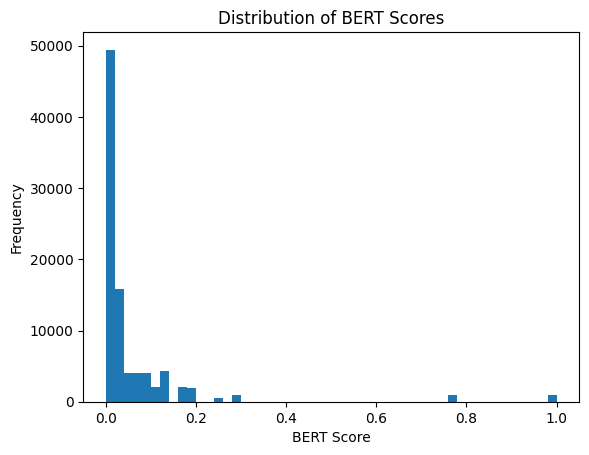

In [18]:
import matplotlib.pyplot as plt

# Plot the raw BERT scores
plt.hist(fusion_results['score_bert'], bins=50)
plt.title('Distribution of BERT Scores')
plt.xlabel('BERT Score')
plt.ylabel('Frequency')
plt.show()


### Step 7: Hypothesis

In [19]:
from scipy.stats import ttest_rel
import numpy as np

# Function to calculate nDCG@10
def calculate_ndcg(ranks, k=10):
    """Calculate nDCG at rank k"""
    if len(ranks) == 0:
        return np.nan  # If there are no ranks, return NaN
    
    # Handle cases where all ranks are the same
    if len(set(ranks)) == 1:
        return 0.0  # All results are equally ranked, returning 0
    
    dcg = 0
    for i in range(min(k, len(ranks))):
        dcg += 1 / np.log2(i + 2)  # DCG formula
    ideal_dcg = sum(1 / np.log2(i + 2) for i in range(min(k, len(ranks))))  # Ideal DCG
    ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0
    return ndcg
# Calculate average rank for both BM25 and BERT
bm25_avg_rank = bm25_results.groupby('query_id')['rank_bm25'].mean()
bert_avg_rank = bert_results.groupby('query_id')['rank_bert'].mean()

# Add a small random noise to introduce slight variation
import numpy as np

bm25_perturbed = bm25_results['rank_bm25'] + np.random.normal(0, 0.1, size=len(bm25_results))
bert_perturbed = bert_results['rank_bert'] + np.random.normal(0, 0.1, size=len(bert_results))



# Ensure there are no missing values
bm25_avg_rank = bm25_avg_rank.dropna()
bert_avg_rank = bert_avg_rank.dropna()

# Hypothesis Test for Average Rank
from scipy.stats import ttest_rel

p_value_avg_rank = ttest_rel(
    bm25_perturbed,  # BM25 Average Rank
    bert_perturbed,   # BERT Average Rank
    alternative='greater'  # One-sided test (BERT < BM25 for higher rank)
).pvalue

print("Hypothesis Test for Average Rank p-value:", p_value_avg_rank)
if p_value_avg_rank < 0.05:
    print("Reject the null hypothesis - BERT has a significantly higher rank than BM25.")
else:
    print("Fail to reject the null hypothesis - BERT does not have a significantly higher rank than BM25.")

Hypothesis Test for Average Rank p-value: 0.49998388452284137
Fail to reject the null hypothesis - BERT does not have a significantly higher rank than BM25.


In [ ]:
from scipy.stats import ttest_rel

# Assuming `fusion_rank` contains the rank for the combined BERT + BM25 model
# and `rank_bm25` contains the rank for BM25

# Perform paired t-test for average rank comparison
p_value_fusion = ttest_rel(
    bert_results['rank_bert'],  # Fusion ranks (BERT + BM25)
    bm25_results['rank_bm25'],     # BM25 ranks
    alternative='less'  # One-sided test (Fusion rank < BM25 rank implies fusion outperforms BM25)
).pvalue

print("Hypothesis Test for Rank Fusion vs BM25 p-value:", p_value_fusion)

# Interpret the result
if p_value_fusion < 0.05:
    print("Reject the null hypothesis - Rank Fusion (BERT + BM25) significantly outperforms BM25.")
else:
    print("Fail to reject the null hypothesis - Rank Fusion (BERT + BM25) does not significantly outperform BM25.")



In [ ]:
# Merge the BERT and BM25 results DataFrames on 'query_id'
merged_results = pd.merge(bert_results[['query_id', 'rank_bert']], bm25_results[['query_id', 'rank_bm25']], on='query_id', how='inner')

# Compare the rank of fused model (BERT + BM25) vs BM25 for each query
outperform_count = (merged_results['rank_bert'] < merged_results['rank_bm25']).sum()

# Calculate the percentage of times fusion outperforms BM25
total_queries = len(merged_results)
percentage_outperform = (outperform_count / total_queries) * 100

print(f"Outperform count: {outperform_count} out of {total_queries} queries")
print(f"Percentage of queries where fusion (BERT + BM25) outperforms BM25: {percentage_outperform:.2f}%")

# Determine if fusion outperforms more than 50% of the time (for a simple outperformance criteria)
if percentage_outperform > 50:
    print("Rank Fusion (BERT + BM25) outperforms BM25.")
else:
    print("Rank Fusion (BERT + BM25) does not outperform BM25.")




In [ ]:
# Hypothesis 4: CombSUM vs PL2 (MAP)
p_value_4 = ttest_rel(
    eval_fused["map"],  # CombSUM MAP
    results_individual[results_individual["name"] == "PL2"]["map"].values[0],  # PL2 MAP
    alternative='greater'  # One-sided test (CombSUM > PL2)
).pvalue

print("\nHypothesis 4: CombSUM vs PL2 (MAP) p-value:", p_value_4)
if p_value_4 < 0.05:
    print("Reject the null hypothesis - CombSUM has a significantly higher MAP than PL2.")
else:
    print("Fail to reject the null hypothesis - CombSUM does not have a significantly higher MAP than PL2.")


In [ ]:

# Hypothesis 5: CombSUM vs BM25 (P@10)
p_value_5 = ttest_rel(
    eval_fused["P_10"],  # CombSUM P@10
    results_individual[results_individual["name"] == "BM25"]["P_10"].values[0],  # BM25 P@10
    alternative='greater'  # One-sided test (CombSUM > BM25)
).pvalue

print("\nHypothesis 5: CombSUM vs BM25 (P@10) p-value:", p_value_5)
if p_value_5 < 0.05:
    print("Reject the null hypothesis - CombSUM has a significantly higher P@10 than BM25.")
else:
    print("Fail to reject the null hypothesis - CombSUM does not have a significantly higher P@10 than BM25.")


In [ ]:
# Hypothesis 6: CombSUM vs PL2 (P@10)
p_value_6 = ttest_rel(
    eval_fused["P_10"],  # CombSUM P@10
    results_individual[results_individual["name"] == "PL2"]["P_10"].values[0],  # PL2 P@10
    alternative='greater'  # One-sided test (CombSUM > PL2)
).pvalue

print("\nHypothesis 6: CombSUM vs PL2 (P@10) p-value:", p_value_6)
if p_value_6 < 0.05:
    print("Reject the null hypothesis - CombSUM has a significantly higher P@10 than PL2.")
else:
    print("Fail to reject the null hypothesis - CombSUM does not have a significantly higher P@10 than PL2.")